In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
df = pd.read_csv(r"C:\Users\rutha\OneDrive\Documents\Customer Churn Project\WA_Fn-UseC_-Telco-Customer-Churn (1).csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Convert TotalCharges from string to numeric.
df = df.dropna(subset=['TotalCharges']) # Drop rows where TotalCharges is missing.
df = df.drop(columns=['customerID']) #Drop customerid as it is not needed.
print(df['Churn'].value_counts()) # Count of churn values

Churn
No     5163
Yes    1869
Name: count, dtype: int64


C:\Users\rutha\AppData\Local\Temp\ipykernel_28044\100921902.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='Set2')


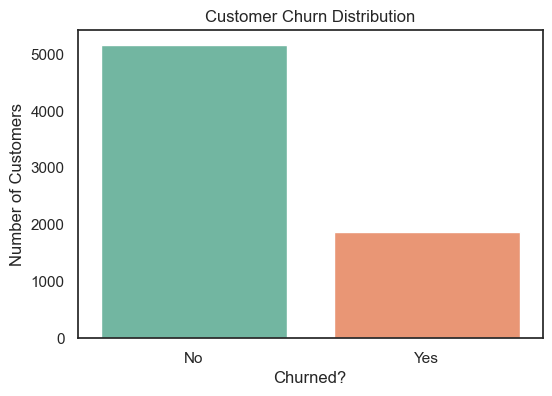

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title("Customer Churn Distribution")
plt.ylabel("Number of Customers")
plt.xlabel("Churned?")
plt.show()

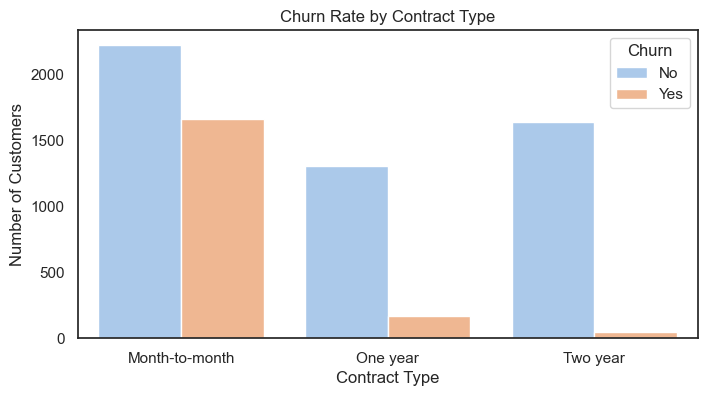

In [27]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Contract', hue='Churn', palette='pastel')
plt.title("Churn Rate by Contract Type")
plt.ylabel("Number of Customers")
plt.xlabel("Contract Type")
plt.show()

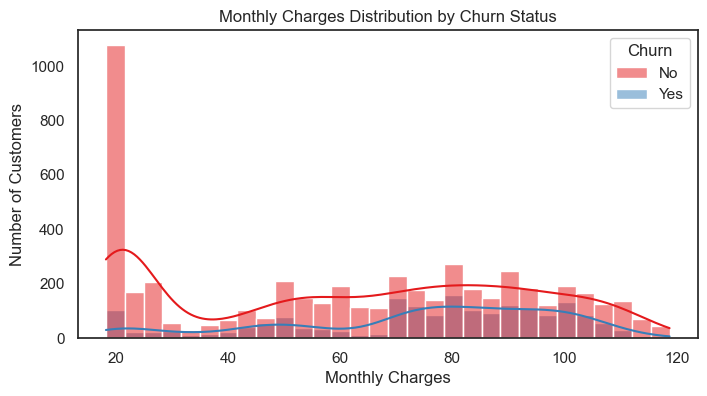

In [28]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', bins=30, kde=True, palette='Set1')
plt.title("Monthly Charges Distribution by Churn Status")
plt.xlabel("Monthly Charges")
plt.ylabel("Number of Customers")
plt.show()

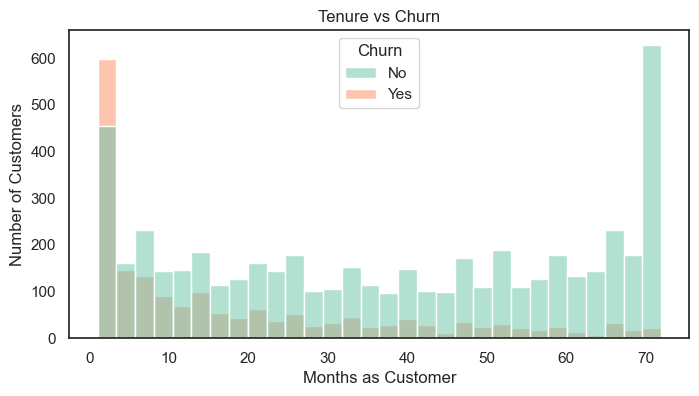

In [29]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=False, palette='Set2')
plt.title("Tenure vs Churn")
plt.xlabel("Months as Customer")
plt.ylabel("Number of Customers")
plt.show()

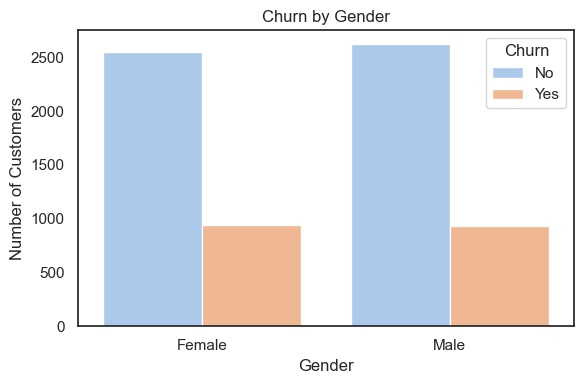

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender', hue='Churn', palette='pastel')
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
df_model = df.copy()
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
le = LabelEncoder()
for col in binary_cols:
    df_model[col] = le.fit_transform(df_model[col])
df_model = pd.get_dummies(df_model, drop_first=True)
X = df_model.drop('Churn', axis=1)  
y = df_model['Churn']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
model = RandomForestClassifier()
model.fit(X_train, y_train) 
joblib.dump(model, "churn_model.pkl")
model = joblib.load("churn_model.pkl")
joblib.dump(X.columns.tolist(), "model_columns.pkl")
model_columns = joblib.load("model_columns.pkl")
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(df.groupby('Churn')['tenure'].mean())
print(df['Contract'].value_counts(normalize=True))
print(df.groupby('Contract')['Churn'].value_counts(normalize=True))
print(df.groupby('Churn')['MonthlyCharges'].mean())


Accuracy: 0.7896233120113717
Confusion Matrix:
 [[928 105]
 [191 183]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Churn
No     37.650010
Yes    17.979133
Name: tenure, dtype: float64
Contract
Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: proportion, dtype: float64
Contract        Churn
Month-to-month  No       0.572903
                Yes      0.427097
One year        No       0.887228
                Yes      0.112772
Two year        No       0.971513
                Yes      0.028487
Name: proportion, dtype: float64
Churn
No     61.307408
Yes    74.441332
Name: MonthlyCharges, dtype: float64


In [32]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
model = joblib.load("churn_model.pkl")
model_columns = joblib.load("model_columns.pkl")
st.title("Customer Churn Prediction App")
st.write("Fill the customer info below to check if they are likely to churn:")
gender = st.selectbox("Gender", ["Male", "Female"])
contract = st.selectbox("Contract Type", ["Month-to-month", "One year", "Two year"])
payment_method = st.selectbox("Payment Method", ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"])
internet_service = st.selectbox("Internet Service", ["DSL", "Fiber optic", "No"])
monthly_charges = st.number_input("Monthly Charges", min_value=0.0)
tenure = st.slider("Tenure (months)", 0, 72)
if st.button("Predict"):
    input_dict = {
        'gender': gender,
        'Contract': contract,
        'PaymentMethod': payment_method,
        'InternetService': internet_service,
        'MonthlyCharges': monthly_charges,
        'tenure': tenure,
    }
    input_df = pd.DataFrame([input_dict])
    for col in model_columns:
        if col not in input_df.columns:
            input_df[col] = 0
    for col in input_df.select_dtypes(include='object').columns:
        input_df[col] = LabelEncoder().fit(df[col]).transform(input_df[col])
    input_df = input_df[model_columns]
    prediction = model.predict(input_df)[0]
    probability = model.predict_proba(input_df)[0][1]
    st.subheader("Prediction:")
    if prediction == 1:
        st.error(f"The customer is likely to churn ({probability*100:.1f}%)")
    else:
        st.success(f"The customer is likely to stay ({100 - probability*100:.1f}%)")

    st.caption("Prediction made using a Random Forest model.")


2025-07-18 21:50:27.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 21:50:27.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 21:50:27.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 21:50:27.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 21:50:27.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 21:50:27.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 21:50:27.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 21:50:27.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar